# Ejemplo de serie temporal utilizando un modelo SARIMA: Johnson&Johnson

Usaremos los datos de ganancias trimestrales de Johnson & Johnson como otro ejemplo ilustrativo de pronóstico con la media móvil regresiva automática estacional **SARIMA**. 

Este conjunto de datos está disponible en el [paquete de conjuntos de datos R](https://stat.ethz.ch/R-manual/R-patched/library/datasets/html/00Index.html).

Los modelos **SARIMA** se pueden escribir como **SARIMA(p,d,q, P, D, Q, S)**. Para ajustar una serie de tiempo, necesitamos determinar los parámetros **p,d,q, P, D, Q, S** (más adelante explicaremos qué significan estos parámetros) y la siguiente lista de verificación puede ser útil:

- **Haz una visualización de la serie**
Esto ayudará a identificar tendencias o estacionalidad y brindará una idea de cuáles son los datos y si se necesita una transformación.

- **Realizar transformaciones de necesidades**
Por lo general, si la serie no es estacionaria debido a una varianza o tendencias no constantes, necesitamos realizar una transformación (por ejemplo, una transformación logarítmica) para que sea estacionaria

- **Realizar diferenciación**
Esto ayudará a identificar el orden de diferenciación necesario para eliminar tendencias o estacionalidad. Vea esta [publicación](https://machinelearningmastery.com/difference-time-series-dataset-python/) o [esta](https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/ ) por ejemplo.

- **Prueba de Ljung**
¿Podemos usar para verificar si hay autocorrelaciones entre observaciones en diferentes lapsos de tiempo?

- **Hacer gráficos ACF**
Se puede utilizar para determinar el orden de los parámetros de los componentes MA
- los picos significativos más cercanos determinan el orden p de MA no estacional
- picos significativos alrededor del retraso estacional determinan el orden de MA estacional

- **Hacer gráficos PACF**
Se puede utilizar para determinar el orden de los parámetros para los componentes AR
- picos significativos más cercanos determinan el orden p de AR no estacional
- picos significativos alrededor del retraso estacional determinan el orden de AR estacional

Empecemos.


In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import datetime
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Cargando los datos

Lo primero que haremos será cargar los datos de ganancias trimestrales de Johnson & Johnson. Los datos van desde 1960 hasta 1980, cada fila representa un año.

In [5]:
df = pd.read_csv("JohnsonJohnson.csv", parse_dates=['year'])
df.tail()

,year,Qtr1,Qtr2,Qtr3,Qtr4
16,1976-01-01,7.74,8.91,8.28,6.84
17,1977-01-01,9.54,10.26,9.54,8.73
18,1978-01-01,11.88,12.06,12.15,8.91
19,1979-01-01,14.04,12.96,14.85,9.99
20,1980-01-01,16.20,14.67,16.02,11.61


# Transformación de los datos

Transformemos los datos colapsando los diferentes trimestres en filas adicionales. Podemos agregar filas de la siguiente manera
- Qrt1 - enero
- Qtr2 - Abril
- Qrt3 - julio
- Qrt4 - Octubre

Entonces, necesitamos crear un rango de fechas que vaya desde 1960 hasta 1980. La longitud debe ser 4 veces la longitud del marco de datos original. Haremos que la frecuencia sea igual a 3 meses

In [8]:
# Esto no tiene ninguna importancia, aquí lo único que hacemos es arreglar un poco los datos

#colapsar los datos agregando 4 filas para cada año
Qtr = []
for i in df.index:
    Qtr +=[
        df.loc[i, 'Qtr1'],
        df.loc[i, 'Qtr2'], 
        df.loc[i, 'Qtr3'], 
        df.loc[i, 'Qtr4']      
    ]

#creo índices desde 1960 a 1980. 
index = pd.date_range('1/1/1960', periods=4*len(df), freq='3M')
ganancias = pd.DataFrame(Qtr, index=index, columns=['Earnings'])
ganancias.index.name = 'Date'
index

DatetimeIndex(['1960-01-31', '1960-04-30', '1960-07-31', '1960-10-31',
               '1961-01-31', '1961-04-30', '1961-07-31', '1961-10-31',
               '1962-01-31', '1962-04-30', '1962-07-31', '1962-10-31',
               '1963-01-31', '1963-04-30', '1963-07-31', '1963-10-31',
               '1964-01-31', '1964-04-30', '1964-07-31', '1964-10-31',
               '1965-01-31', '1965-04-30', '1965-07-31', '1965-10-31',
               '1966-01-31', '1966-04-30', '1966-07-31', '1966-10-31',
               '1967-01-31', '1967-04-30', '1967-07-31', '1967-10-31',
               '1968-01-31', '1968-04-30', '1968-07-31', '1968-10-31',
               '1969-01-31', '1969-04-30', '1969-07-31', '1969-10-31',
               '1970-01-31', '1970-04-30', '1970-07-31', '1970-10-31',
               '1971-01-31', '1971-04-30', '1971-07-31', '1971-10-31',
               '1972-01-31', '1972-04-30', '1972-07-31', '1972-10-31',
               '1973-01-31', '1973-04-30', '1973-07-31', '1973-10-31',
      

In [9]:
ganancias.head()

,Earnings
Date,
1960-01-31,0.71
1960-04-30,0.63
1960-07-31,0.85
1960-10-31,0.44
1961-01-31,0.61


In [10]:
ganancias.tail()

,Earnings
Date,
1979-10-31,9.99
1980-01-31,16.20
1980-04-30,14.67
1980-07-31,16.02
1980-10-31,11.61


Una vez que hemos estudiado como son nuestros datos, procedemos a visualizar qué pintas tienen

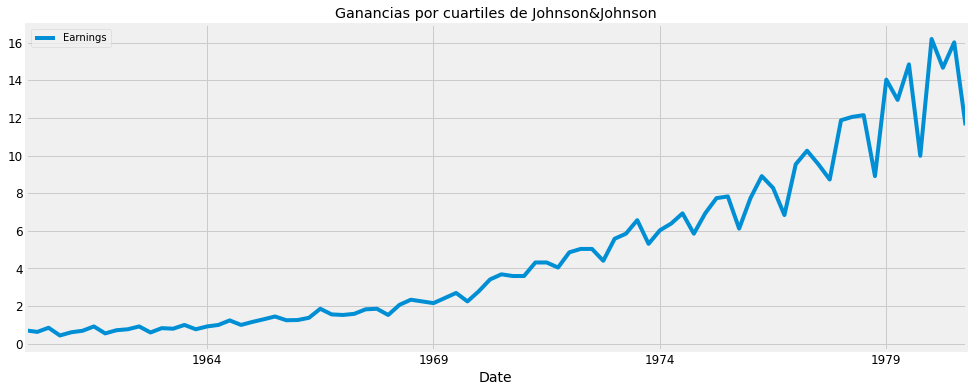

In [12]:
gan = ganancias.plot(figsize=(15, 6), title='Ganancias por cuartiles de Johnson&Johnson')

# Descomposición de la serie

Podemos usar un método de descomposición de series temporales para descomponer nuestra serie temporal en tres componentes distintos:
- Tendencia
- Estacionalidad
- Ruido

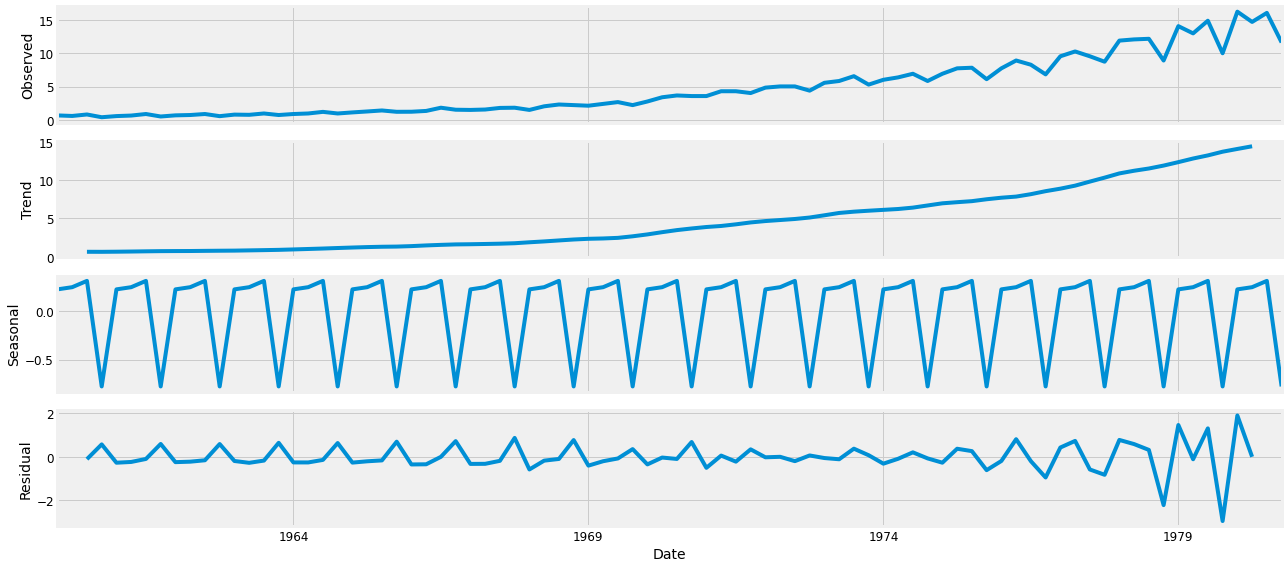

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(ganancias, model='additive')
fig = decomposition.plot()

El gráfico muestra claramente que los datos de ventas no son estacionarios.
- Hay una tendencia clara, las ganancias han ido aumentando a lo largo de los años. **Tendremos que realizar la diferenciación.**
- Hay estacionalidad, bastante consistente a lo largo de los años. Ya sabemos que la frecuencia es 4 pero veremos como estimarla más adelante
- El término de ruido parece tener una varianza diferente, **tendremos que realizar una transformación** 


# Mirar los gráficos ACF y PACF

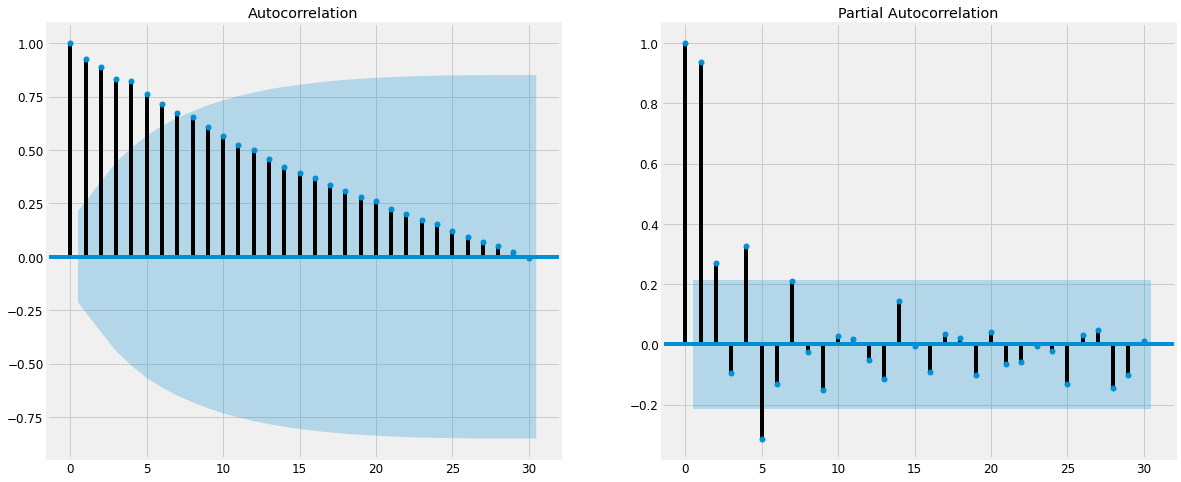

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure()
ax1 = fig.add_subplot(121)
plot_acf(ganancias, lags=30, ax=ax1)
ax2 = fig.add_subplot(122)
plot_pacf(ganancias, lags=30, ax=ax2)
plt.show()

- El ACF decae muy lentamente. Esto suele ser una indicación, un indicio de que se necesita diferenciar
- A partir del PACF, podemos inferir que el período estacional S=4 y estamos viendo quizás el modelo AR(1)

# Transformar los datos para convertir la serie en estacionaria

In [17]:
# Vemos que la serie tiene heterocedasticidad y no conserva su varianza constante a lo largo del tiempo

#Lo primero que podemos hacer es aplicarle la transformación más usada (la logarítmica)
logy = np.log(ganancias)

#Then differencing to remove trends
dlogy = logy.diff(periods=1).dropna()

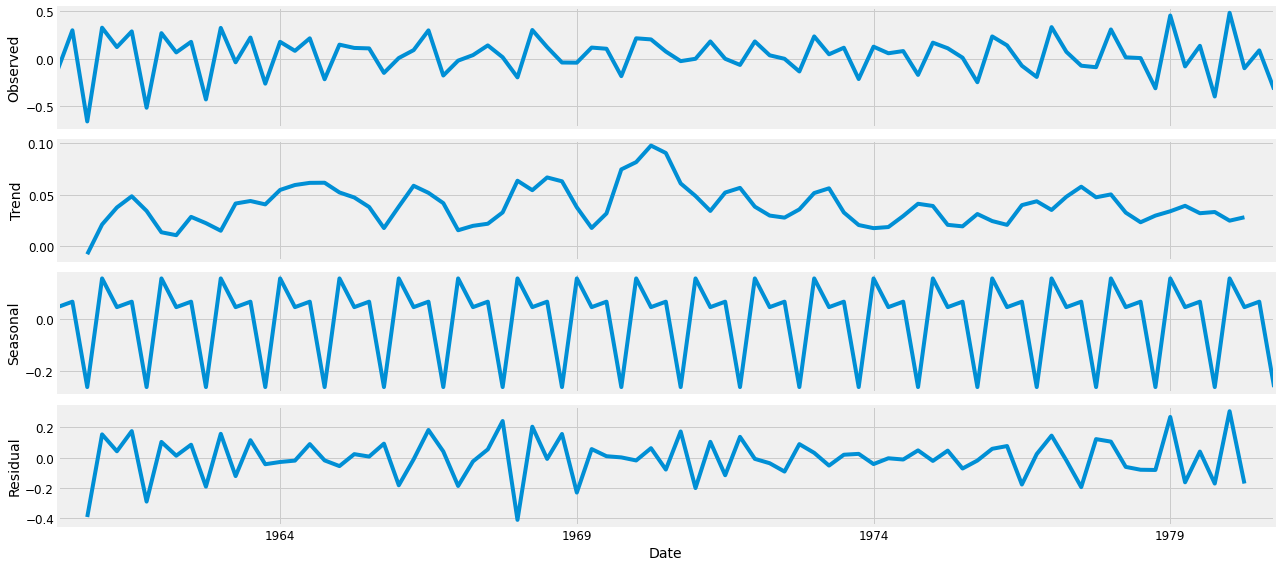

In [18]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(dlogy, model='additive')
fig = decomposition.plot()

- Ahora la serie temporal aparece más o menos estacionaria
- Se ha eliminado la tendencia sistemática.
- Los residuales todavía muestran una varianza no constante, pero es mejor que antes (podríamos calcular la varianza de la serie)  

# Ajustamos la serie con un modelo SARIMA

Podemos usar un método clásico para el análisis de series de tiempo **SARIMA** que significa Promedio Móvil Integrado Auto Regresivo Estacional. Los modelos **SARIMA** se escriben **SARIMA$(p, d, q, P, D, Q)_S$** donde

- **p** es el orden del componente Auto Regresivo (cómo el pasado afecta el presente)
- **d** es el orden de la diferencia necesaria para eliminar tendencias sistemáticas en los datos
- **q** es el orden del componente Media Móvil (efectos de ruido, lo que no sabemos)
- **P, D, Q** son orden equivalente para los efectos estacionales.

Entonces la pregunta es ¿cómo determinamos p, d, q, P, D, Q?

## Desarrollar la intuición de las órdenes usando ACF y PACF

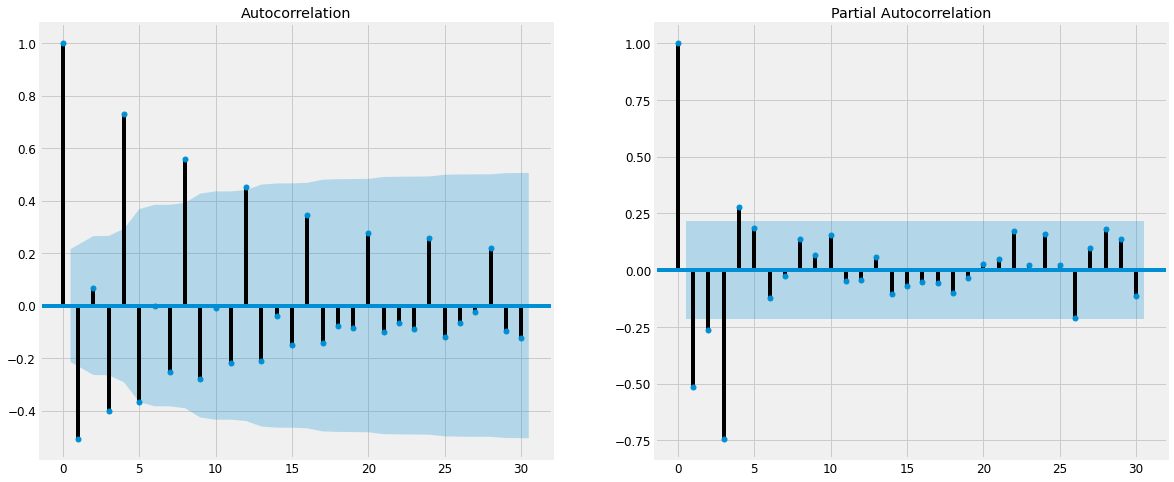

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure()
ax1 = fig.add_subplot(121)
plot_acf(dlogy, lags=30, ax=ax1)
ax2 = fig.add_subplot(122)
plot_pacf(dlogy, lags=30, ax=ax2)
plt.show()

**Del gráfico de autocorrelación ACF**
- Podemos inferir una estructura de corte después del desfase 1 en la parte MA no estacional (posible q = 0, 1)
- La parte MA estacional muestra un patrón de descomposición. tal vez Q = 0? (necesitamos mirar el gráfico PACF para decidir)
- El lento decaimiento en el componente estacional también sugiere que necesitamos alguna diferenciación estacional, es decir, D = 1 ?
- Período estacional S = 4

**Del gráfico de autocorrelación parcial ACF**
- Vemos una estructura de corte en la parte no estacional con alrededor de 2 retrasos significativos (sugerimos p = 0,1,2)
- La parte AR estacional también muestra una estructura de corte que desaparece después de aproximadamente 2 períodos (posible P = 0,1,2)

**¿Cómo determinamos d?**
- Necesitábamos tomar la diferencia de primer orden para eliminar la tendencia, entonces d=1
- El decaimiento lento en la parte estacional que se muestra en el gráfico ACF sugiere que tal vez D=1

**Aplicar el principio de parsimonia**
La idea aquí es que debemos usar el modelo más simple posible que mejor se ajuste a los datos. La regla dice así:

$$p + d + q + P + D + Q \lt 6$$

**El modelo posible de ACF y PACF es SARIMA(p=1, d=1, q=0, P=1, D=1, Q=0, S=4)**

## ¿Usar búsqueda en Grid?

Con la intuición de las gráficas ACF y PACF, tenemos un rango estrecho de parámetros para buscar. También podemos usar
**Búsqueda en Grid (Grid Search)** para encontrar el mejor modelo (que minimiza el AIC o SSE)

In [20]:
def grid_search(y, pdq, seasonal_pdq):

    warnings.filterwarnings("ignore")
    aic = {}
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                name = param+param_seasonal
                aic[name] = results.aic
                #print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return aic

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]
print('Finding Best Parameter combinations for Seasonal ARIMA...')

aic = grid_search(logy, pdq, seasonal_pdq)
#get the model with minimum aic : min(dict, key=dict.get) will return the key with minimum value in dict
print("Model with Minimum AIC of {} is {}".format(aic[min(aic, key=aic.get)], min(aic, key=aic.get)))

Finding Best Parameter combinations for Seasonal ARIMA...
Model with Minimum AIC of -157.3688317328705 is (1, 0, 1, 1, 0, 1, 4)


El resultado anterior sugiere que **SARIMA(1, 0, 1)x(1, 0, 1, 4)** produce el valor AIC más bajo. Por lo tanto, debemos considerar que esta es la opción óptima.
Encontramos usando ACF y PACF que un posible modelo puede ser **SARIMA(1, 1, 0)x(1, 1, 0, 4)**. Podemos probar los dos pero me quedo con el segundo

## Ajustando el modelo

In [21]:
mod = sm.tsa.statespace.SARIMAX(logy,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5233      0.092     -5.687      0.000      -0.704      -0.343
ar.S.L4       -0.3161      0.115     -2.750      0.006      -0.541      -0.091
sigma2         0.0081      0.002      4.995      0.000       0.005       0.011


El resumen anterior muestra que:
- El coeficiente estimado para el componente AR es significativo ya que el valor p es pequeño
- El parámetro estimado para el componente MA es significativo
- La desviación estándar estimada del término de ruido es significativa.

## Diagnóstico del modelo

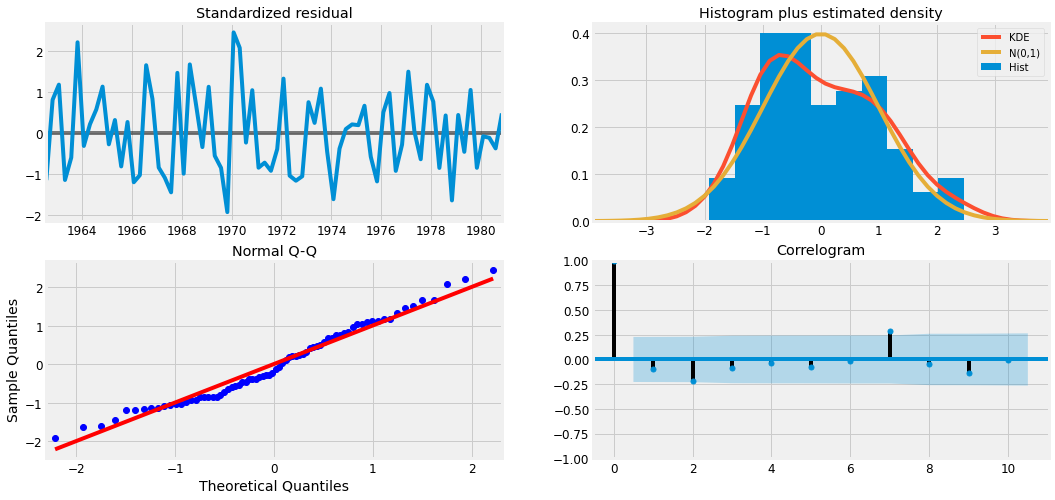

In [22]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

¿Qué buscamos en el gráfico anterior?
- Los residuos deben tener una distribución normal con media 0. El primer gráfico parece confirmarlo.
- El histograma también parece una aproximación decente de la distribución normal
- El gráfico Q-Q debe ser lineal, se ve bastante lineal
- No debería haber correlación entre los residuos, el diagrama de correlograma parece apoyar eso


## Validando nuestro modelo 

In [23]:
logy.head()

,Earnings
Date,
1960-01-31,-0.342490
1960-04-30,-0.462035
1960-07-31,-0.162519
1960-10-31,-0.820981
1961-01-31,-0.494296


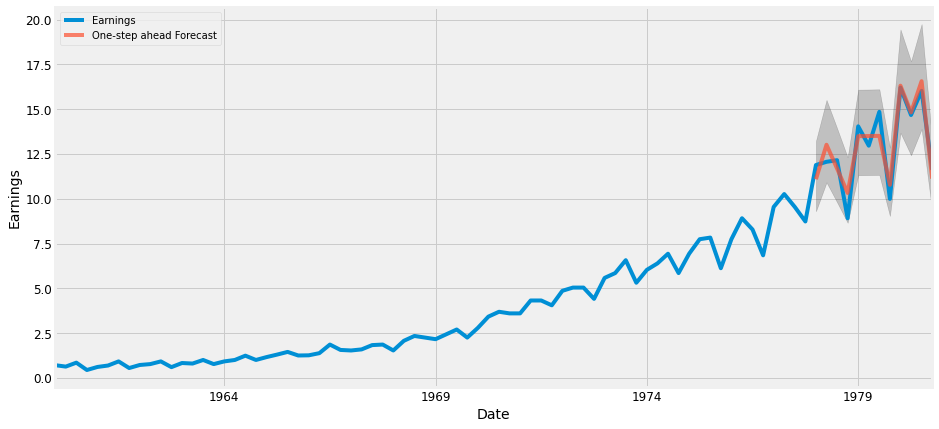

In [26]:
#Hagamos algunas previsiones a partir del 31-01-1978 hasta el final de los datos.
pred = results.get_prediction(start=pd.to_datetime('1978-01-31'), dynamic=False)
pred_ci = pred.conf_int()

e_logy = np.exp(logy)
ax = logy.apply(np.exp)['1960':].plot(label='observed')

pred.predicted_mean.apply(np.exp).plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                np.exp(pred_ci.iloc[:, 0]),
                np.exp(pred_ci.iloc[:, 1]), 
                color='k', 
                alpha=.2
               )

ax.set_xlabel('Date')
ax.set_ylabel('Earnings')
plt.legend(loc='upper left')
plt.show()

In [27]:
# Calculamos algunas métricas de error

y_truth = np.exp(logy['1978-01-31':]).values
y_forecasted = np.exp(pred.predicted_mean).values.reshape(y_truth.shape)
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Mean = {}, MSE = {}, RMSE = {}'.format(round(y_truth.mean(), 2), round(mse, 2), round(mse**(0.5),2)))

Mean = 12.94, MSE = 0.61, RMSE = 0.78


## Realizamos pronóstico

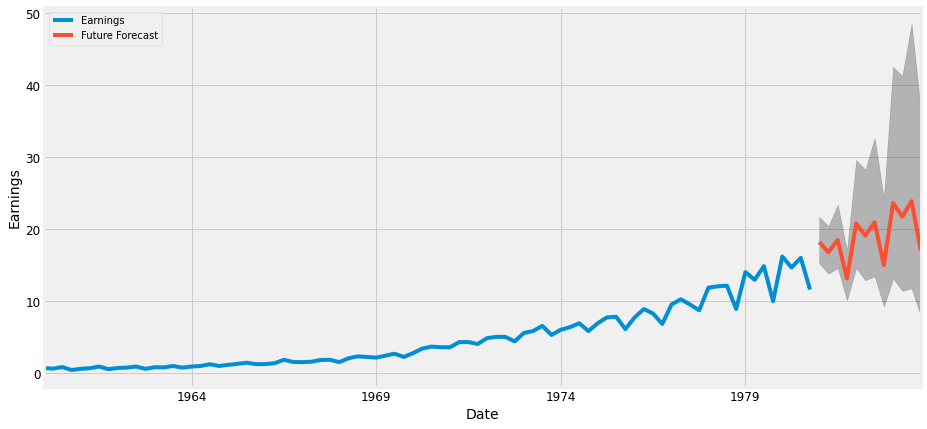

1981-01-31    18.202092
1981-04-30    16.798784
1981-07-31    18.500217
1981-10-31    13.142072
1982-01-31    20.786569
1982-04-30    19.087767
1982-07-31    20.954388
1982-10-31    14.983789
1983-01-31    23.630330
1983-04-30    21.735220
1983-07-31    23.883793
1983-10-31    17.043340
Freq: 3M, dtype: float64

In [28]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y.plot(figsize=(14, 7))

pred_uc.predicted_mean.apply(np.exp).plot(ax=ax, label='Future Forecast')
ax.fill_between(pred_ci.index,
                np.exp(pred_ci.iloc[:, 0]),
                np.exp(pred_ci.iloc[:, 1]), 
                color='k', 
                alpha=.25
               )

ax.set_xlabel('Date')
ax.set_ylabel('Earnings')
plt.legend(loc='upper left')
plt.show()
pred_uc.predicted_mean.apply(np.exp)

¡No está mal! Podemos hacer previsiones para los próximos dos años. Es obvio que tenemos menos confianza en el pronóstico a medida que miramos más hacia el futuro.

**Useful Links** 

- [Facebook Prophet](https://research.fb.com/prophet-forecasting-at-scale/)
- [Resampling Time Series](http://benalexkeen.com/resampling-time-series-data-with-pandas/)
- [Prophet with PyMC3](https://www.ritchievink.com/blog/2018/10/09/build-facebooks-prophet-in-pymc3-bayesian-time-series-analyis-with-generalized-additive-models/)
- [11 Methods for Time Series Analysis](https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/)